In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt, ceil

sns.set_theme()

## Temporal Modelling (ARIMA)
In this notebook we apply an ARIMA model to the 3 datasets, and attempt to predict the last 30 days in the dataset. 
First we define the fitting and plotting functions we will use for all datasets. We utilize the pmdarima package for fitting and forecasting, and Seaborn for plotting the results.

In [125]:
def autoARIMAfunc(df):
    
    # Training data split
    train_df = df.iloc[:-30]  
    test_df = df.iloc[-30:]
    
    # define output dataframes
    forecast_df = pd.DataFrame(index = test_df.index)
    upper_df = pd.DataFrame(index = test_df.index)
    lower_df = pd.DataFrame(index = test_df.index)
    fit_df = pd.DataFrame(index = train_df.index)
    
    columns = df.columns
    for col in columns[1:]:
        # apply auto_arima. will estimate the pdq x PDQ model paramenters
        model = pm.auto_arima(train_df[col], seasonal=True, start_p=0, start_q=0, max_p=10, max_q=10, trace=True)
        # generate forecast and confidence intervals
        forecast, confidenceInt = model.predict(30, return_conf_int=True)
        forecast_df[col] = forecast
        lower_df[col] = confidenceInt[:,0]
        upper_df[col] = confidenceInt[:,1]
        fit_df[col] = model.fittedvalues()
        
    return train_df, test_df, fit_df, forecast_df, lower_df, upper_df
    

In [126]:
def autoARIMAfunc2(df):
    
    # Training data split
    train_df = df.iloc[:-30]  
    test_df = df.iloc[-30:]
    
    # define output dataframes
    forecast_df = pd.DataFrame(index = test_df.index)
    upper_df = pd.DataFrame(index = test_df.index)
    lower_df = pd.DataFrame(index = test_df.index)
    fit_df = pd.DataFrame(index = train_df.index)
    
    columns = df.columns
    for col in columns[1:]:
        
        # apply auto_arima. will estimate the pdq x PDQ model paramenters
        model = pm.auto_arima(train_df[col], seasonal=True, start_p=0, start_q=0, max_p=10, max_q=10, trace=True)
        # generate forecast and confidence intervals
        forecast, confidenceInt = model.predict(30, return_conf_int=True)
        forecast_df[col] = forecast
        lower_df[col] = confidenceInt[:,0]
        upper_df[col] = confidenceInt[:,1]
        fit_df[col] = model.fittedvalues()
        
    return train_df, test_df, fit_df, forecast_df, lower_df, upper_df

In [127]:
def plotARIMAfunc(train_df, test_df, fit_df, forecast_df, lower_df, upper_df):   
    columns = train_df.columns
    k = ceil(len(columns)/2)
    fig, axs = plt.subplots(nrows=k, ncols=2, figsize=(30, k*5))
    i = 0
    j = 0
    palette = sns.color_palette()
    for col in columns[1:]:
        # Plot data and fitted model
        sns.lineplot(x = train_df.timestamp.iloc[-300:], y = train_df[col].iloc[-300:], ax=axs[i,j], color=palette[0], label="Actual")
        sns.lineplot(x = train_df.timestamp.iloc[-300:], y = fit_df[col].iloc[-300:], ax=axs[i,j], color=palette[1], label="Forecast")
        sns.lineplot(x = test_df.timestamp, y = test_df[col], ax=axs[i,j], color=palette[0])
        sns.lineplot(x = test_df.timestamp, y = forecast_df[col], ax=axs[i,j], color=palette[1])
        # plot confidence interval
        axs[i,j].fill_between(test_df.timestamp, lower_df[col], upper_df[col], alpha=0.2)
        
        # print RMSE, and add legend and labels
        rmse = sqrt(mean_squared_error(test_df[col], forecast_df[col]))
        print(f'RMSE for {col} Stations: {rmse}')
        axs[i,j].set_title(col + f", Forecast RMSE: {rmse}")
        axs[i,j].set_xlabel('')
        axs[i,j].set_ylabel('Energy (kWh)')
        axs[i,j].legend(loc='upper left')
        
        j += 1
        if j >= 2:
            i += 1
            j = 0
            
    plt.show()

In [128]:
def plotARIMAfunc2(dict):   
    k = ceil(len(dict.keys())/2)
    fig, axs = plt.subplots(nrows=k, ncols=2, figsize=(30, k*5))
    i = 0
    j = 0
    palette = sns.color_palette()
    for col in dict.keys():
        # Plot data and fitted model
        sns.lineplot(x = dict[col]["train"].timestamp.iloc[-300:], y = dict[col]["train"][col].iloc[-300:], ax=axs[i,j], color=palette[0], label="Actual")
        sns.lineplot(x = dict[col]["train"].timestamp.iloc[-300:], y = dict[col]["fit"][col].iloc[-300:], ax=axs[i,j], color=palette[1], label="Forecast")
        sns.lineplot(x = dict[col]["test"].timestamp, y = dict[col]["test"][col], ax=axs[i,j], color=palette[0])
        sns.lineplot(x = dict[col]["test"].timestamp, y = dict[col]["forecast"][col], ax=axs[i,j], color=palette[1])
        # plot confidence interval
        axs[i,j].fill_between(dict[col]["test"].timestamp, dict[col]["lower"][col], dict[col]["upper"][col], alpha=0.2)
        
        # print RMSE, and add legend and labels
        rmse = sqrt(mean_squared_error(dict[col]["test"][col], dict[col]["forecast"][col]))
        print(f'RMSE for {col} Stations: {rmse}')
        axs[i,j].set_title(col + f", Forecast RMSE: {rmse}")
        axs[i,j].set_xlabel('')
        axs[i,j].set_ylabel('Energy (kWh)')
        axs[i,j].legend(loc='upper left')
        
        j += 1
        if j >= 2:
            i += 1
            j = 0
            
    plt.show()

## Palo Alto

In [129]:
PA_data = pd.read_csv('data/EVChargingStationUsage.csv')

C:\Users\pgsva\AppData\Local\Temp\ipykernel_23600\1309580590.py:1: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  PA_data = pd.read_csv('data/EVChargingStationUsage.csv')


In [130]:
# format station names to merge chargers at same location
PA_data["Normalized Station Name"] = PA_data["Station Name"].str.split(pat=" / | #| [0-9]").apply(lambda col: col[1])
PA_data.dropna(subset=['Normalized Station Name'], inplace=True)

In [131]:
stations = PA_data["Normalized Station Name"].unique()

In [132]:
# transform timestamp to Datetime object and simplify to dates
PA_data = PA_data.assign(timestamp=pd.to_datetime(PA_data["Transaction Date (Pacific Time)"], format="%m/%d/%Y %H:%M", errors='coerce').dt.date)
# group energy consumption around dates and station
PA_data = PA_data[["timestamp", "Normalized Station Name", "Energy (kWh)"]].groupby(["timestamp", "Normalized Station Name"], as_index=False).sum()
# Pivot energy consumption data to have rows indexed on dates and columns indexed on stations
PA_data = pd.pivot_table(PA_data, values="Energy (kWh)", index="timestamp", columns= "Normalized Station Name", aggfunc=np.sum, fill_value=0)
PA_data.reset_index(inplace=True)
PA_data["timestamp"] = pd.to_datetime(PA_data["timestamp"])

In [133]:
PA_dict = {station: {"data":PA_data[["timestamp", station]][(PA_data.loc[::-1, station].ne(0).cummax()) & (PA_data.loc[:, station].ne(0).cummax())]} for station in stations}
for station in stations:
    date_range = pd.date_range(start=PA_dict[station]["data"]["timestamp"].min(), end=PA_dict[station]["data"]["timestamp"].max())
    dataframe = pd.DataFrame({"timestamp": date_range})
    PA_dict[station]["data"] = pd.merge(dataframe, PA_dict[station]["data"], on=["timestamp"], how="left")
    PA_dict[station]["data"][station] = PA_dict[station]["data"][station].fillna(0)
    

In [134]:
for station in stations:
    val = PA_dict[station]["data"][PA_dict[station]["data"] == 0].count(axis=0)/len(PA_dict[station]["data"].index)
    print(f'{station}:\t {val[station]} \t {len(PA_dict[station]["data"].index)}')

HAMILTON:	 0.004133451431945674 	 3387
HIGH:	 0.01760046934584922 	 3409
BRYANT:	 0.013333333333333334 	 3375
MPL:	 0.009162303664921465 	 2292
RINCONADA LIB:	 0.0044731610337972166 	 2012
WEBSTER:	 0.005042864346949067 	 1983
TED THOMPSON:	 0.011025358324145534 	 1814
CAMBRIDGE:	 0.005512679162072767 	 1814
SHERMAN:	 0.17391304347826086 	 23


In [135]:
del PA_dict["SHERMAN"]

In [136]:
#train_df_PA, test_df_PA, fit_df_PA, forecast_df_PA, lower_df_PA, upper_df_PA = autoARIMAfunc(PA_data)
for station in PA_dict.keys():
    PA_dict[station]["train"], PA_dict[station]["test"], PA_dict[station]["fit"], PA_dict[station]["forecast"], PA_dict[station]["lower"], PA_dict[station]["upper"] = autoARIMAfunc2(PA_dict[station]["data"])

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33854.011, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33144.213, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=32087.486, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33852.012, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=32064.525, Time=0.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=32063.835, Time=1.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=32889.341, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=32041.416, Time=1.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=32715.227, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=32012.016, Time=1.56 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=32591.975, Time=0.35 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=31916.693, Time=2.12 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=32251.807, Time=0.41 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=31864.925, Time=2.53 sec
 ARIMA(6,1,0)(0,0,0

RMSE for HAMILTON Stations: 31.98942380709641
RMSE for HIGH Stations: 36.060299647279734
RMSE for BRYANT Stations: 48.34275231139173
RMSE for MPL Stations: 24.664259183221418
RMSE for RINCONADA LIB Stations: 38.250215101904026
RMSE for WEBSTER Stations: 40.436609483655765
RMSE for TED THOMPSON Stations: 31.025064848722767
RMSE for CAMBRIDGE Stations: 54.01940336229967


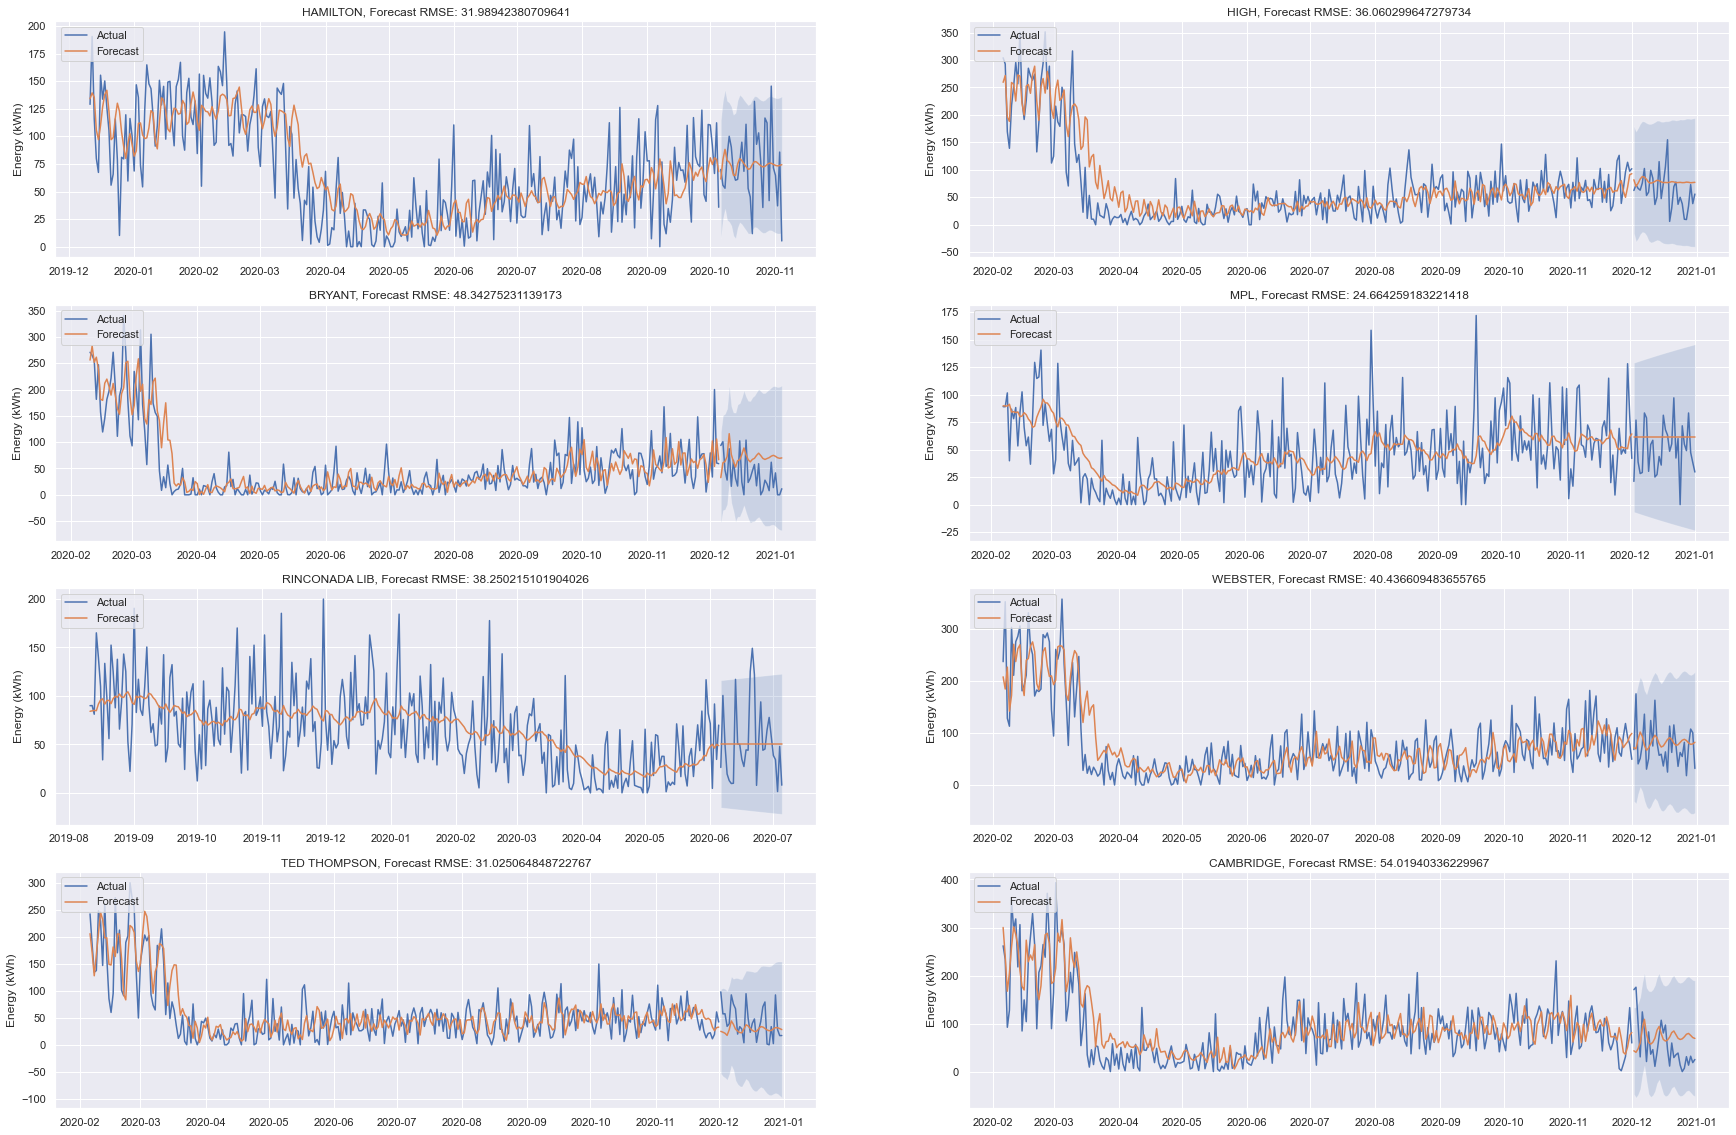

In [137]:
#plotARIMAfunc(train_df_PA, test_df_PA, fit_df_PA, forecast_df_PA, lower_df_PA, upper_df_PA)
plotARIMAfunc2(PA_dict)

To understand the shortcomings of the datasets we identify the number of dates with no charging data for a given station

## Dundee

In [138]:
data_dundee = pd.read_csv('data/Dundee_merged.csv')

C:\Users\pgsva\AppData\Local\Temp\ipykernel_23600\1761076983.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data_dundee = pd.read_csv('data/Dundee_merged.csv')


In [139]:
mapping = {
    'Trades Lane': 'Trades Lane, Dundee',
    'South Tay Street': 'South Tay Street, Dundee', 
    'Sinclair Street':  'Sinclair Street, Dundee',
}
data_dundee["Address 1"] = data_dundee["Address 1"].replace(mapping)
stations = data_dundee["Address 1"].unique()

In [140]:
data_dundee = data_dundee.assign(timestamp=pd.to_datetime(data_dundee["End Date"]).dt.date)
data_dundee = data_dundee[["timestamp", "Address 1", "Energy(kWh)"]].groupby(["timestamp", "Address 1"], as_index=False).sum()
data_dundee = pd.pivot_table(data_dundee, values="Energy(kWh)", index="timestamp", columns= "Address 1", aggfunc=np.sum, fill_value=0)
data_dundee.reset_index(inplace=True)
data_dundee["timestamp"] = pd.to_datetime(data_dundee["timestamp"])
data_dundee = data_dundee.iloc[1:]

In [141]:
dundee_dict = {station: {"data":data_dundee[["timestamp", station]][(data_dundee.loc[::-1, station].ne(0).cummax()) & (data_dundee.loc[:, station].ne(0).cummax())]} for station in stations}
for station in stations:
    date_range = pd.date_range(start=dundee_dict[station]["data"]["timestamp"].min(), end=dundee_dict[station]["data"]["timestamp"].max())
    dataframe = pd.DataFrame({"timestamp": date_range})
    dundee_dict[station]["data"] = pd.merge(dataframe, dundee_dict[station]["data"], on=["timestamp"], how="left")
    dundee_dict[station]["data"][station] = dundee_dict[station]["data"][station].fillna(0)
    

In [142]:
data_dundee.head(10)

Address 1  timestamp  ***TEST SITE*** Charge Your Car HQ  \
1         2017-09-01                                 0.0   
2         2017-09-02                                 0.0   
3         2017-09-03                                 0.0   
4         2017-09-04                                 0.0   
5         2017-09-05                                 0.0   
6         2017-09-06                                 0.0   
7         2017-09-07                                 0.0   
8         2017-09-08                                 0.0   
9         2017-09-09                                 0.0   
10        2017-09-10                                 0.0   

Address 1  Ardler Complex, Dundee  Balunie Drive, Dundee  \
1                            0.00                   2.08   
2                            0.00                  47.17   
3                            0.00                  30.94   
4                            0.00                  23.19   
5                            0.00                  22.27   
6                            0.00                  47.46   
7                            0.00                   0.00   
8                            7.21                  26.97   
9                            0.00                  25.24   
10                           0.00                   0.00   

Address 1  Brington Place Sheltered Housing, Dundee  \
1                                             14.06   
2                                              7.69   
3                                            -10.46   
4                                             18.50   
5                                             12.44   
6                                             11.67   
7                                             19.10   
8                                              8.42   
9                                              9.46   
10                                            20.36   

Address 1  DCC Environment, 34 Harefield Road  Dock Street, Dundee  \
1                                        1.36                7.623   
2                                       11.17               36.744   
3                                        0.00                9.593   
4                                       20.75               16.714   
5                                        4.03               17.464   
6                                       12.08               15.542   
7                                        0.00               19.081   
8                                       11.81               16.365   
9                                       15.33                5.485   
10                                       0.00               19.983   

Address 1  Dundee House, Dundee  Dundee Ice Arena, Dundee  \
1                          5.72                   245.582   
2                          0.00                   340.500   
3                          0.00                   269.280   
4                         13.98                   186.840   
5                         24.21                   221.061   
6                         37.35                   295.905   
7                         34.98                   297.950   
8                         28.42                   330.680   
9                          0.00                   319.501   
10                         0.00                   432.652   

Address 1  Earn Cresent, Dundee  ...  Princes Street Charging Hub  \
1                          0.00  ...                          0.0   
2                         15.13  ...                          0.0   
3                          0.00  ...                          0.0   
4                          0.00  ...                          0.0   
5                          0.00  ...                          0.0   
6                         10.96  ...                          0.0   
7                          9.54  ...                          0.0   
8                         45.88  ...                          0.0   
9       

In [143]:
for station in stations:
    val = dundee_dict[station]["data"][dundee_dict[station]["data"] == 0].count(axis=0)/len(dundee_dict[station]["data"].index)
    print(f'{station}:\t {val[station]} \t {len(dundee_dict[station]["data"].index)}')

Lochee Charging Hub, Dundee:	 0.0 	 151
Greenmarket Multi Car Park, Dundee:	 0.0026954177897574125 	 371
Queen Street Car Park, Broughty Ferry, Dundee:	 0.0026954177897574125 	 371
Housing Office West, Dundee:	 0.16129032258064516 	 372
Nethergate, Dundee:	 0.12096774193548387 	 372
Princes Street Charging Hub:	 0.0 	 51
Brington Place Sheltered Housing, Dundee:	 0.03763440860215054 	 372
Balunie Drive, Dundee:	 0.2553763440860215 	 372
Social Work Building, Jack Martin Way, Dundee:	 0.043010752688172046 	 372
Dundee Ice Arena, Dundee:	 0.0862533692722372 	 371
Mitchell Street, Dundee:	 0.6704225352112676 	 355
Oakland Day Centre, Dundee:	 0.48342541436464087 	 362
Dock Street, Dundee:	 0.0456989247311828 	 372
Whitfield Centre, Dundee:	 0.10483870967741936 	 372
Housing Office East, Dundee:	 0.16129032258064516 	 372
Gellatly Street Car Park, Dundee:	 0.005361930294906166 	 373
Dundee House, Dundee:	 0.29301075268817206 	 372
Public Works Dept, Clepington Rd. Dundee:	 0.01344086021505

In [144]:
del dundee_dict["***TEST SITE*** Charge Your Car HQ"]

In [145]:
#train_df_dundee, test_df_dundee, fit_df_dundee, forecast_df_dundee, lower_df_dundee, upper_df_dundee = autoARIMAfunc(data_dundee)
for station in dundee_dict.keys():
    dundee_dict[station]["train"], dundee_dict[station]["test"], dundee_dict[station]["fit"], dundee_dict[station]["forecast"], dundee_dict[station]["lower"], dundee_dict[station]["upper"] = autoARIMAfunc2(dundee_dict[station]["data"])

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1618.241, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1590.893, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1596.574, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1984.423, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1592.325, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1592.708, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1594.696, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1624.509, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.328 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3834.142, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3792.192, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3766.318, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3832.142, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=375

RMSE for Lochee Charging Hub, Dundee Stations: 208.60896013899418
RMSE for Greenmarket Multi Car Park, Dundee Stations: 40.47197713921022
RMSE for Queen Street Car Park, Broughty Ferry, Dundee Stations: 48.23791997063745
RMSE for Housing Office West, Dundee Stations: 10.689849325160386
RMSE for Nethergate, Dundee Stations: 12.461098677387
RMSE for Princes Street Charging Hub Stations: 186.6791967052794
RMSE for Brington Place Sheltered Housing, Dundee Stations: 4.979151556128777
RMSE for Balunie Drive, Dundee Stations: 14.18148302486625
RMSE for Social Work Building, Jack Martin Way, Dundee Stations: 7.255191021629935
RMSE for Dundee Ice Arena, Dundee Stations: 117.47620302844592
RMSE for Mitchell Street, Dundee Stations: 4.5630226926502795
RMSE for Oakland Day Centre, Dundee Stations: 9.554038321265786
RMSE for Dock Street, Dundee Stations: 20.74486745041446
RMSE for Whitfield Centre, Dundee Stations: 22.855460406104566
RMSE for Housing Office East, Dundee Stations: 17.52222741380289


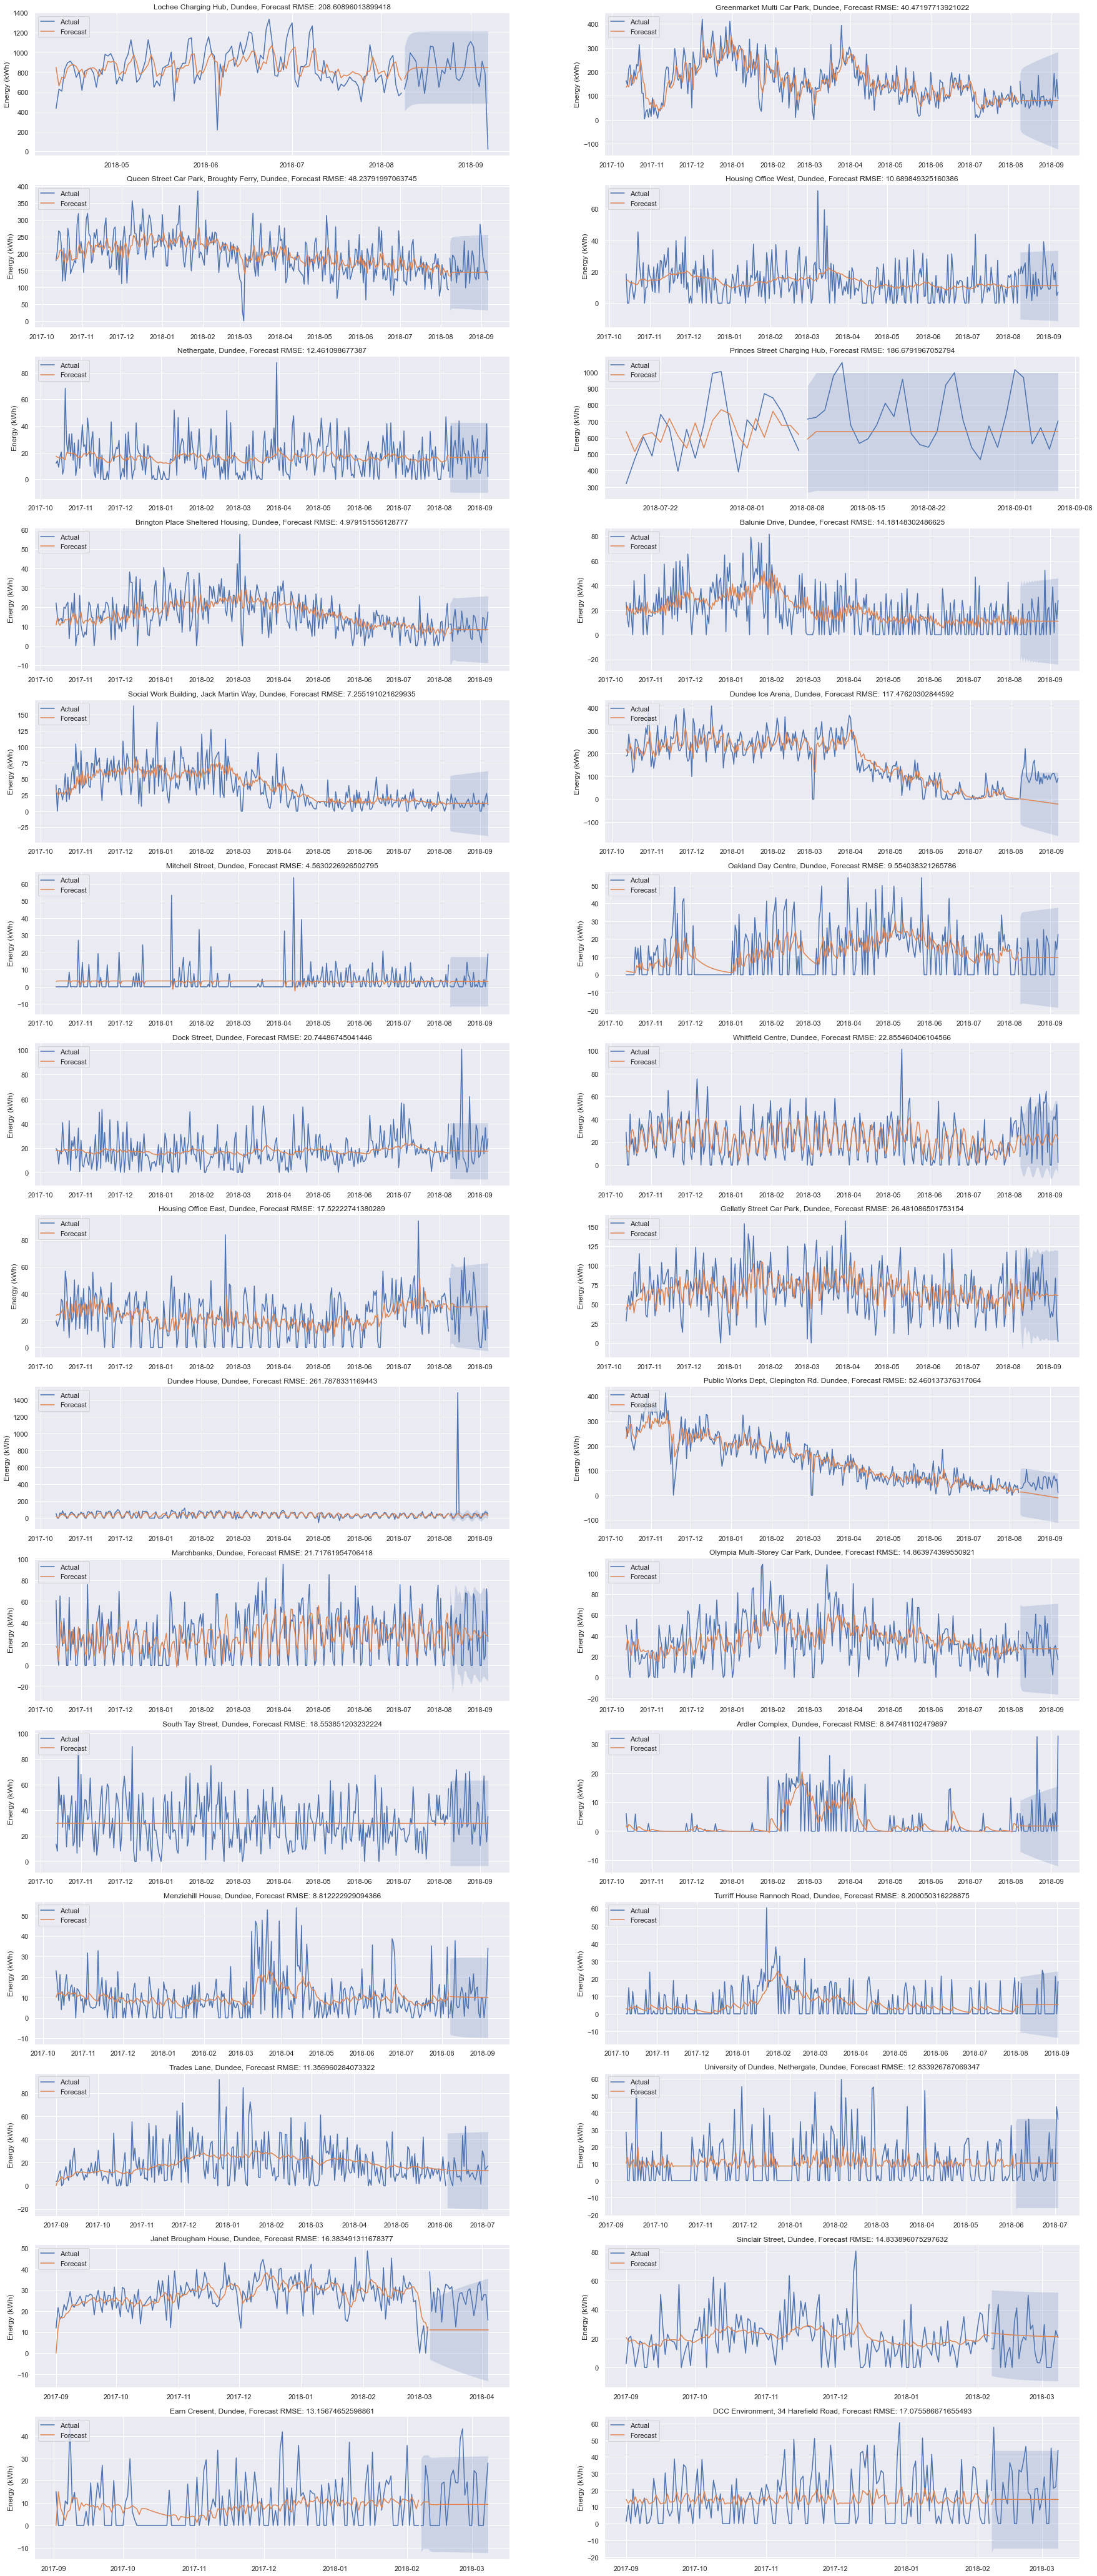

In [146]:
#plotARIMAfunc(train_df_dundee, test_df_dundee, fit_df_dundee, forecast_df_dundee, lower_df_dundee, upper_df_dundee)
plotARIMAfunc2(dundee_dict)

## Perth

In [147]:
df_1 = pd.read_csv('data/EV_ChargeStation_Use_Sept_2016_to_Aug_2017.csv', index_col=[0]).drop(columns=['OBJECTID'])
df_2 = pd.read_csv('data/EVChargeStationUseSept2017toAug2018.csv', index_col=[0])
df_3 = pd.read_csv('data/EVChargeStationUseSept2018toAug2019.csv', index_col=[0])

df_1 = df_1[df_1['Site'] != '***TEST SITE*** Charge Your Car HQ']
df_3 = df_3[df_3['Site'] != '***TEST SITE*** Charge Your Car HQ']

In [148]:

# Define a mapping dictionary for renaming
rename_mapping = {
    'King Street Car Park, Crieff': 'King Street Car Park',
    'Broxden Park & Ride, Perth': 'Broxden Park & Ride',
    'Canal Street Car Park 3rd floor, Perth': 'Canal Street Car Park',
    'Canal Street Car Park 3rd floor ': 'Canal Street Car Park',
    'Friarton Depot, Perth': 'Friarton Depot',
    'South Inch Car Park, Perth': 'South Inch Car Park',
    'Kinross Park and Ride, Kinross': 'Kinross Park and Ride',
    ' Leslie Street Car Park, Blairgowrie': 'Leslie Street Car Park, Blairgowrie',
}

# Replace the values in the 'Site' column using the mapping
df_1['Site'] = df_1['Site'].replace(rename_mapping)
df_2['Site'] = df_2['Site'].replace(rename_mapping)
df_3['Site'] = df_3['Site'].replace(rename_mapping)

df_1 = df_1.rename(columns={
    'CP_ID': 'CP ID',
    'Start_Date': 'Start Date',
    'Start_Time': 'Start Time',
    'End_Date': 'End Date',
    'End_Time': 'End Time',
    'Total_kWh': 'Total kWh'
})

# Union data
data_perth = pd.concat([df_1, df_2, df_3]).drop_duplicates()

# Drop records with below 0 Total kWh
data_perth = data_perth[data_perth['Total kWh'] >= 0]

# Drop two stations (too little data)
#data_perth = data_perth[data_perth['Site'] != 'Market Square Alyth']
#data_perth = data_perth[data_perth['Site'] != 'Mill Street, Perth']

In [149]:
data_perth.head()

CP ID  Connector           Start Date Start Time             End Date  \
_id                                                                          
1    51519          2  2017/08/31 00:00:00   22:12:00  2017/08/31 00:00:00   
2    51250          1  2017/08/31 00:00:00   22:01:00  2017/08/31 00:00:00   
3    50575          2  2017/08/31 00:00:00   21:21:00  2017/08/31 00:00:00   
4    51516          2  2017/08/31 00:00:00   20:43:00  2017/08/31 00:00:00   
5    50994          2  2017/08/31 00:00:00   19:50:00  2017/08/31 00:00:00   

     End Time  Total kWh                                   Site  \
_id                                                               
1    23:11:00      18.27                    Broxden Park & Ride   
2    22:31:00      19.45  Crown Inn Wynd Car Park, Auchterarder   
3    21:59:00      19.71                    South Inch Car Park   
4    21:03:00       9.84                  Kinross Park and Ride   
5    20:50:00      14.17    Leslie Street Car Park, Blairgowrie   

                            Model  
_id                                
1        APT Triple Rapid Charger  
2    Siemens Triple Rapid Charger  
3        APT Triple Rapid Charger  
4        APT Triple Rapid Charger  
5        APT Triple Rapid Charger

In [150]:
stations = data_perth["Site"].unique()

In [151]:
data_perth = data_perth.assign(timestamp=pd.to_datetime(data_perth["Start Date"]).dt.date)
data_perth = data_perth[["timestamp", "Site", "Total kWh"]].groupby(["timestamp", "Site"], as_index=False).sum()
data_perth = pd.pivot_table(data_perth, values="Total kWh", index="timestamp", columns= "Site", aggfunc=np.sum, fill_value=0)
data_perth.reset_index(inplace=True)
data_perth["timestamp"] = pd.to_datetime(data_perth["timestamp"])

In [152]:
data_perth

Site  timestamp  Atholl Street Car Park, Dunkeld  Broxden Park & Ride  \
0    2016-01-09                            0.000              111.820   
1    2016-01-10                            0.000              134.360   
2    2016-01-11                            0.000               90.670   
3    2016-01-12                            0.000              105.014   
4    2016-02-09                            0.000               59.211   
...         ...                              ...                  ...   
1090 2019-12-04                           39.174              198.414   
1091 2019-12-05                           59.682              107.571   
1092 2019-12-06                           29.338              189.394   
1093 2019-12-07                           15.440              342.782   
1094 2019-12-08                           67.789              227.317   

Site  Canal Street Car Park  Crown Inn Wynd Car Park, Auchterarder  \
0                     0.000                                  0.000   
1                     0.000                                  0.380   
2                     0.000                                  0.000   
3                     0.000                                  0.000   
4                     0.000                                  5.820   
...                     ...                                    ...   
1090                 10.064                                 35.979   
1091                  0.000                                 49.180   
1092                 50.008                                 73.523   
1093                 30.845                                 55.829   
1094                 37.519                                112.902   

Site  Friarton Depot  King Street Car Park  Kinross Park and Ride  \
0             35.370                 0.000                 42.435   
1              0.000                25.172                 83.798   
2             35.930               100.149                 68.370   
3             45.780                 4.030                134.090   
4              0.000                 0.000                 56.630   
...              ...                   ...                    ...   
1090          47.753                31.058                116.072   
1091           0.000                83.894                236.344   
1092          72.499                72.792                263.845   
1093          20.380                33.170                227.842   
1094          34.740               106.708                295.120   

Site  Leslie Street Car Park, Blairgowrie  Market Square Alyth  \
0                                  13.234                  0.0   
1                                   0.000                  0.0   
2                                  35.475                  0.0   
3                                  61.890                  0.0   
4                                   9.540                  0.0   
...                                   ...                  ...   
1090                                0.000                  0.0   
1091                                5.822                  0.0   
1092                               29.646                  0.0   
1093                                8.430                  0.0   
1094                               59.715                  0.0   

Site  Mill Street, Perth  Moness Terrace Car Park, Aberfeldy  \
0                  0.000                               0.000   
1                  0.000                              42.324   
2                  0.000                               0.000   
3                  0.000                               6.800   
4                  0.000                               0.000   
...                  ...                                 ...   
1090             113.791                              90.670   
1091              86.514                             149.029   
1092              66.042                              38.923   
1093              94

In [153]:
perth_dict = {station: {"data":data_perth[["timestamp", station]][(data_perth.loc[::-1, station].ne(0).cummax()) & (data_perth.loc[:, station].ne(0).cummax())]} for station in stations}
for station in stations:
    date_range = pd.date_range(start=perth_dict[station]["data"]["timestamp"].min(), end=perth_dict[station]["data"]["timestamp"].max())
    dataframe = pd.DataFrame({"timestamp": date_range})
    perth_dict[station]["data"] = pd.merge(dataframe, perth_dict[station]["data"], on=["timestamp"], how="left")
    perth_dict[station]["data"][station] = perth_dict[station]["data"][station].fillna(0)

In [154]:
for station in stations:
    val = perth_dict[station]["data"][perth_dict[station]["data"] == 0].count(axis=0)/len(perth_dict[station]["data"].index)
    print(f'{station}:\t {val[station]} \t {len(perth_dict[station]["data"].index)}')

Broxden Park & Ride:	 0.23426573426573427 	 1430
Crown Inn Wynd Car Park, Auchterarder:	 0.31280615815255425 	 1429
South Inch Car Park:	 0.24055944055944056 	 1430
Kinross Park and Ride:	 0.23706293706293707 	 1430
Leslie Street Car Park, Blairgowrie:	 0.2923076923076923 	 1430
Canal Street Car Park:	 0.17820867959372114 	 1083
King Street Car Park:	 0.27501749475157455 	 1429
Moness Terrace Car Park, Aberfeldy:	 0.33869839048285516 	 1429
Atholl Street Car Park, Dunkeld:	 0.3527204502814259 	 1066
Rie-Achan Road Car Park, Pitlochry:	 0.2629370629370629 	 1430
Friarton Depot:	 0.3958041958041958 	 1430
Mill Street, Perth:	 0.37945791726105566 	 701
Market Square Alyth:	 0.8594771241830066 	 306


In [155]:
#train_df_perth, test_df_perth, fit_df_perth, forecast_df_perth, lower_df_perth, upper_df_perth = autoARIMAfunc(data_perth)
for station in perth_dict.keys():
    perth_dict[station]["train"], perth_dict[station]["test"], perth_dict[station]["fit"], perth_dict[station]["forecast"], perth_dict[station]["lower"], perth_dict[station]["upper"] = autoARIMAfunc2(perth_dict[station]["data"])

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15744.895, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15503.090, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15419.700, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15742.899, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15336.361, Time=0.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15295.951, Time=0.53 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15475.325, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15297.596, Time=1.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15297.641, Time=0.83 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15302.799, Time=0.61 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=15452.254, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=15295.630, Time=0.98 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=15295.150, Time=1.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=15299.457, Time=0.82 sec
 ARIMA(5,1,2)(0,0,0

RMSE for Broxden Park & Ride Stations: 126.904405466381
RMSE for Crown Inn Wynd Car Park, Auchterarder Stations: 34.775025436243375
RMSE for South Inch Car Park Stations: 42.50114599120255
RMSE for Kinross Park and Ride Stations: 119.6182900876299
RMSE for Leslie Street Car Park, Blairgowrie Stations: 26.549268286894087
RMSE for Canal Street Car Park Stations: 16.86186370874403
RMSE for King Street Car Park Stations: 46.40838142553116
RMSE for Moness Terrace Car Park, Aberfeldy Stations: 37.761245699321776
RMSE for Atholl Street Car Park, Dunkeld Stations: 29.71125278939365
RMSE for Rie-Achan Road Car Park, Pitlochry Stations: 48.0642921867045
RMSE for Friarton Depot Stations: 17.685868069563917
RMSE for Mill Street, Perth Stations: 37.95257857164468
RMSE for Market Square Alyth Stations: 1.3883826240621686


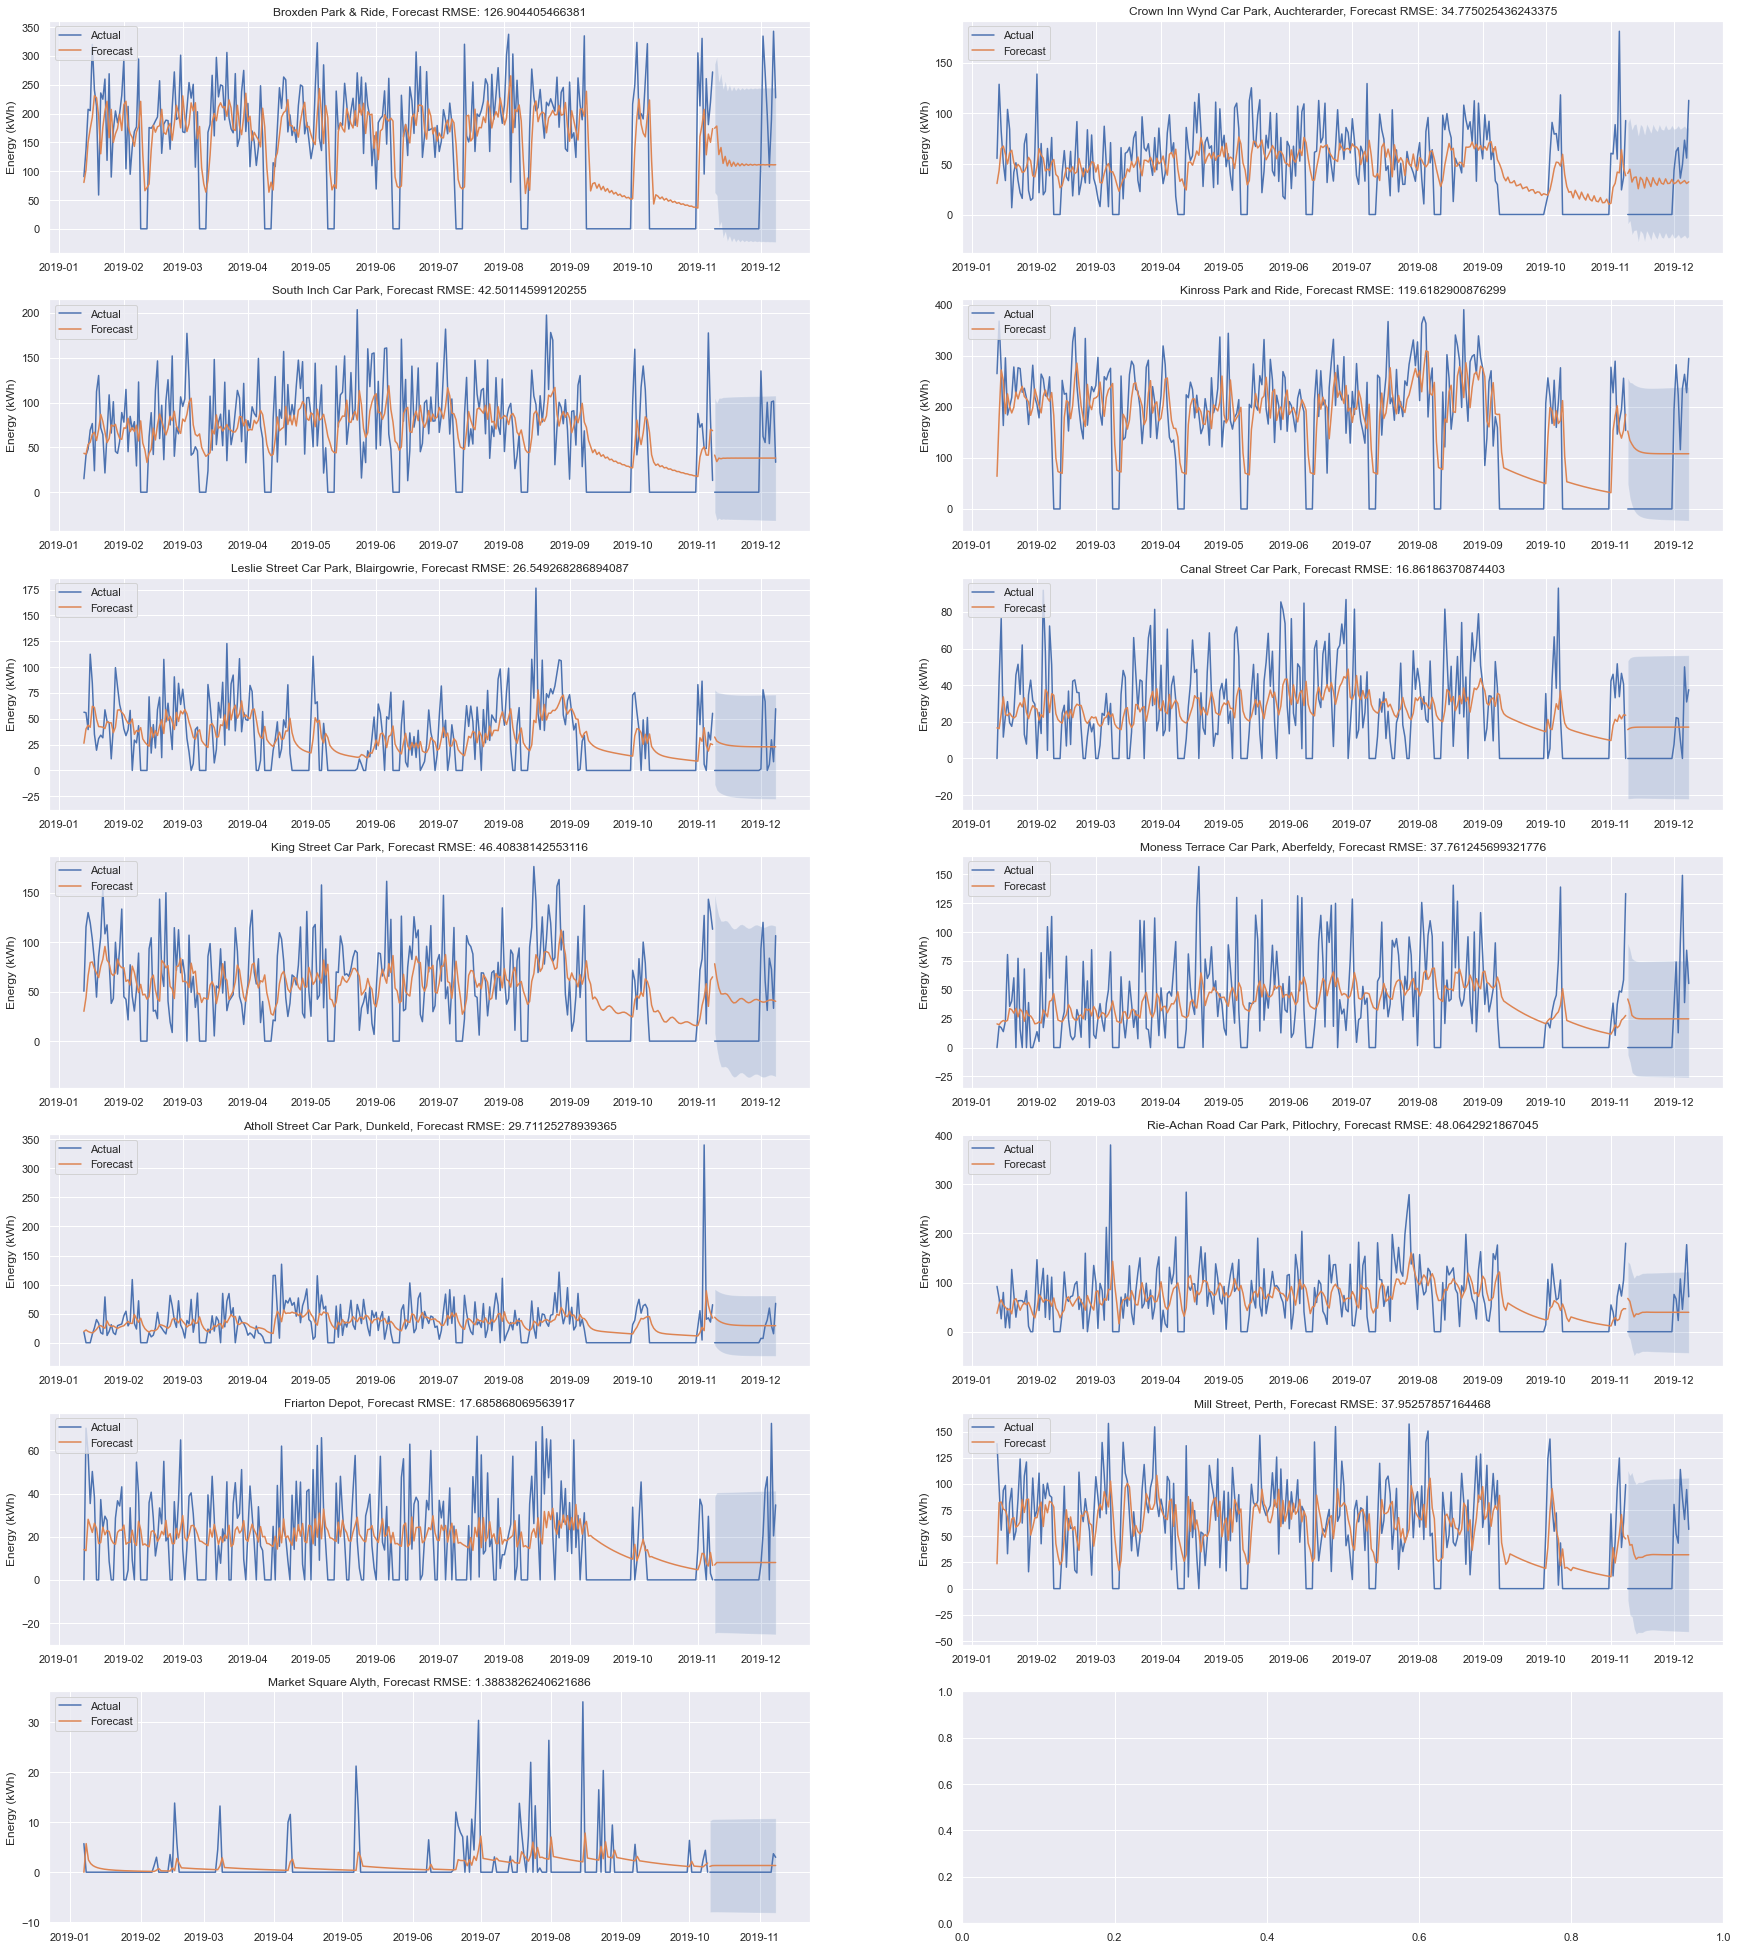

In [156]:
#plotARIMAfunc(train_df_perth, test_df_perth, fit_df_perth, forecast_df_perth, lower_df_perth, upper_df_perth)
plotARIMAfunc2(perth_dict)